# Mapping a Bus Ride in 3D

Tutorial by Will Geary ([@wgeary](https://twitter.com/))

Presented at [PyCon Ghana](https://gh.pycon.org/) at University of Ghana on August 10, 2018

This notebook walks through wrangling GPS data and mapping it onto an animated 3D globe using [Cesium](https://cesiumjs.org/demos/Wayfinder3D/), a javascript library for 3D mapping. 

## 1) Go out and collect some GPS data

There are many free mobile apps for collecting GPS data. Pick any one of them and be sure that the app is able to export data to a `.gpx` file, which is the standard format for GPS data.

I used [Strava](strava.com) to record a bus ride that I took from Hohoe, a town in the mountains of Ghana's Volta Region, to my home in Accra.

Below is a map and some statistics created by Strava:

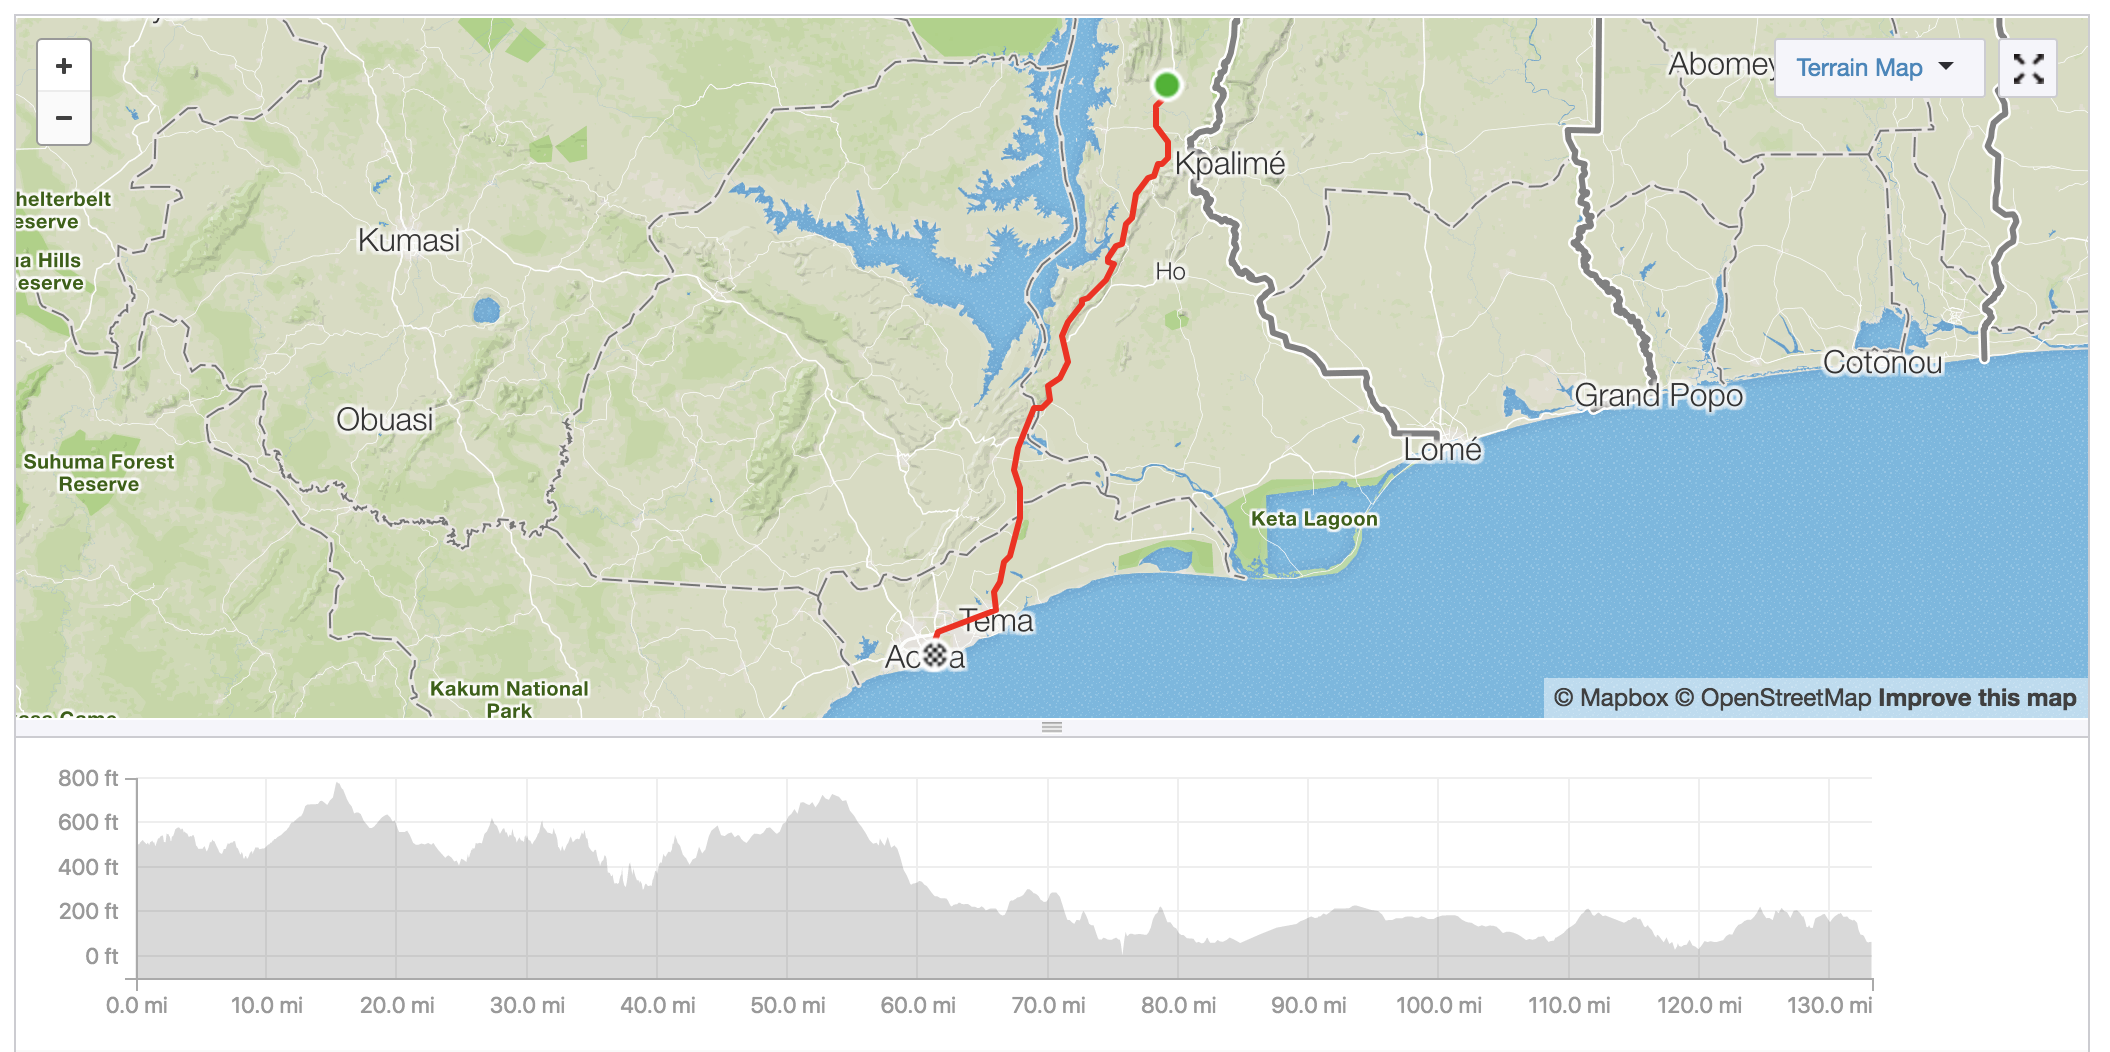

In [1]:
from IPython.display import Image
Image("Hohoe_to_Accra_map.png")

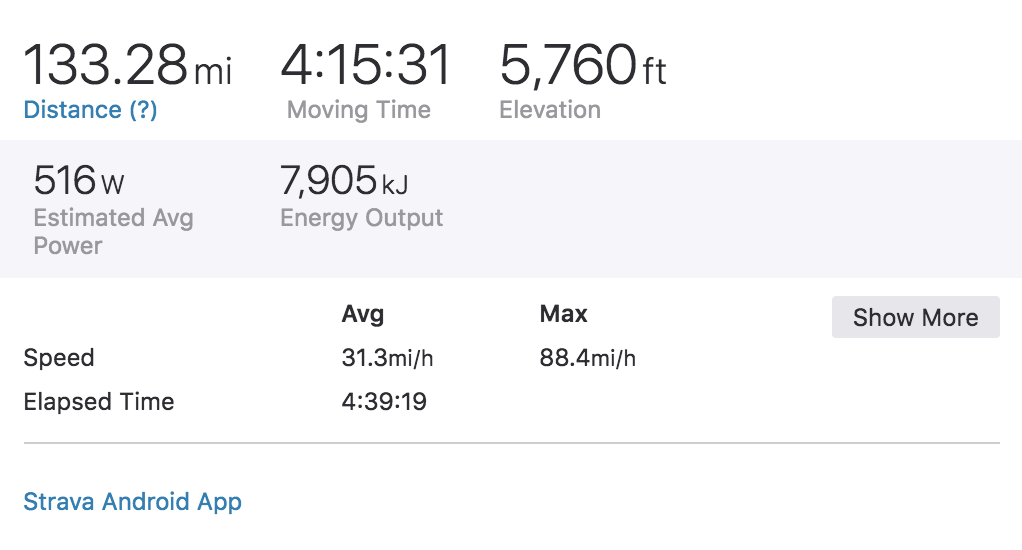

In [2]:
from IPython.display import Image
Image("Hohoe_to_Accra_stats.png")

## 2) Import Python libraries

We will rely on a few excellent Python libraries, including:

- Pandas for data wrangling
- Numpy for fast computing
- gpxpy for handling `.gpx` files
- json for creating `.json` data

In [3]:
import pandas as pd
import numpy as np
import gpxpy
import json

## 3) Read the `.gpx` file

First, lets open the `.gpx` file and read it with `gpxpy`.

In [5]:
gpx_file = open('Hohoe_to_Accra.gpx', 'r')
gpx = gpxpy.parse(gpx_file)

## 4) Parse the `.gpx` file

Now, let's gather the imporant pieces from the `.gpx` file and create a pandas dataframe.

In [6]:
def parse_gpx(gpx_input_file):
    
    # Initialize some lists to store data
    lats = []
    lons = []
    elevations = []
    timestamps = []
    
    # Loop through the .gpx file
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                lats.append(point.latitude)
                lons.append(point.longitude)
                elevations.append(point.elevation)
                timestamps.append(point.time)
       
    # Create and output a dataframe
    output = pd.DataFrame()
    output['latitude'] = lats
    output['longitude'] = lons
    output['elevation'] = elevations
    output['starttime'] = timestamps
    output['stoptime'] = output['starttime'].shift(-1).fillna(method='ffill')
    output['duration'] = (output['stoptime'] - output['starttime']) / np.timedelta64(1, 's') ## duration to seconds
    
    return output

Here's our gps dataframe:

In [7]:
df = parse_gpx(gpx)
df.head()

,latitude,longitude,elevation,starttime,stoptime,duration
0,7.121793,0.458424,157.1,2018-08-05 19:13:02,2018-08-05 19:13:04,2.0
1,7.121728,0.458393,157.0,2018-08-05 19:13:04,2018-08-05 19:13:05,1.0
2,7.121654,0.458383,156.9,2018-08-05 19:13:05,2018-08-05 19:13:06,1.0
3,7.121604,0.458376,156.8,2018-08-05 19:13:06,2018-08-05 19:13:07,1.0
4,7.121571,0.458363,156.7,2018-08-05 19:13:07,2018-08-05 19:13:08,1.0


# 5) Create CZML path

Now, let's create a path object using Cesium's `czml` JSON schema. 

You can read more about czml here: https://github.com/AnalyticalGraphicsInc/czml-writer/wiki/CZML-Guide 

In [8]:
def create_czml_path(df_input):
    
    # Initialize a list to store data
    output = []
    
    # Start timer at zero
    timestep = 0
    
    # Loop through the dataframe
    for i in df_input.index:
        output.append(timestep)
        output.append(df_input.longitude.loc[i])
        output.append(df_input.latitude.loc[i])
        output.append(df_input.elevation.loc[i])
        
        # Keep track of time
        duration = df_input.duration.loc[(i)]
        timestep += duration
        
    return output

Here are the first 12 items in our `czml` path. You will recognize them as timestep, longitude, latitude, elevation, etc.

In [9]:
czml_path = create_czml_path(df)
czml_path[:12]

[0,
 0.458424,
 7.121793,
 157.1,
 2.0,
 0.458393,
 7.121728,
 157.0,
 3.0,
 0.458383,
 7.121654,
 156.9]

## 6) Create final `.json` file with additional properties

Finally, let's create a full `czml` document, which a point, path and style attributes (such as color, default speed, etc).

If you are curious, please read more about Cesium's [point](https://github.com/AnalyticalGraphicsInc/czml-writer/wiki/Point) and [path](https://github.com/AnalyticalGraphicsInc/czml-writer/wiki/Path) objects.

In [10]:
def create_json(df_input, time_multiplier = 1000):
    
    # Store output in array
    output = []

    # Define global variables
    global_id = "document"
    global_name = "Visualizing GPX Data from Strava"
    global_version = "1.0"
    global_author = "Will Geary"
    global_starttime = str(min(df_input['starttime'])).replace(" ", "T").replace(".000", "Z")
    global_stoptime = str(max(df_input['stoptime'])).replace(" ", "T").replace(".000", "Z")
    global_availability = global_starttime + "/" + global_stoptime    
    
    # Create packet with global variables
    global_element = {
        "id" : global_id,
        "name" : global_name,
        "version" : global_version,
        "author": global_author,
        "clock": {
            "interval": global_availability,
            "currentTime": global_starttime,
            "multiplier": time_multiplier
        }
    }
    
    # Append global packet to output
    output.append(global_element)
    
    # Define path variables
    path_id = "path"
    path_starttime = str(min(df_input['starttime'])).replace(" ", "T").replace(".000", "Z")
    path_stoptime = str(max(df_input['starttime'])).replace(" ", "T").replace(".000", "Z")
    path_availability = path_starttime + "/" + path_stoptime
    
    # Create path object
    path_object = {
            "id": path_id,

            "availability": path_availability,

            "position": {
                "epoch": path_starttime,
                "cartographicDegrees": create_czml_path(df)
            },

            "path" : {
                "material" : {
                    "polylineOutline" : {
                        "color" : {
                            "rgba" : [255,255,255, 200]
                        },
                        "outlineColor" : {
                            "rgba" : [0,173,253, 200]
                        },
                        "outlineWidth" : 5
                    }
                },
                "width" : 6,
                "leadTime" : 0,
                "trailTime" : 100000,
                "resolution" : 5
            }
        }

    # Append path element to output
    output.append(path_object)
        
    # Define point variable
    point_id = "Point"
    point_starttime = str(min(df_input['starttime'])).replace(" ", "T").replace(".000", "Z")
    point_stoptime = str(max(df_input['starttime'])).replace(" ", "T").replace(".000", "Z")
    point_availability = point_starttime + "/" + point_stoptime
    
    point_object = {
            "id": point_id,

            "availability": point_availability,

            "position": {
                "epoch": point_starttime,
                "cartographicDegrees": create_czml_path(df)
            },

            "point": {
                "color": {
                    "rgba": [255, 255, 255, 255]
                },
                "outlineColor": {
                    "rgba": [0,173,253, 255]
                },
                "outlineWidth":6,
                "pixelSize":8,
                "heightReference" : "RELATIVE_TO_GROUND"
            }   
        }

    output.append(point_object)
    
    return output

In [11]:
json_output = create_json(df)

Save data to `json` file.

In [12]:
with open('hohoe_accra.czml', 'w') as outfile:
    json.dump(json_output, outfile)

## Visualize data with `Cesium`

Finally, the fun part -- making the map! Import the `cesiumpy` library and add our `czml` JSON file as a data source. 

In [13]:
import cesiumpy

In [14]:
# Ignore warnings
import warnings
warnings.simplefilter("ignore")

In [15]:
data_source = cesiumpy.CzmlDataSource('hohoe_accra.czml')
viewer = cesiumpy.Viewer()
viewer.dataSources.add(data_source)
viewer